In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from navec import Navec
import warnings
warnings.filterwarnings('ignore')

path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [205]:
path = 'Ready_to_use_data'
df = pd.read_csv(path)
df = df.iloc[np.where((df.department != ' ') & (df.unit != ' '))]
df.full_description = df.department + ' ' + df.unit + ' ' + df.job_name

In [207]:
df[['full_description','func_1']]

,full_description,func_1
0,маркетинг дизайн и онлайн продажи департамент ...,Маркетинг
1,управление крупным частным капиталом департаме...,Инвестиционная деятельность
2,крупный корпоративный и инвестиционный бизнес ...,Корпоративный бизнес
3,управление рисками департамент рисков рознично...,Управление рисками
4,малый и микро корпоративный бизнес департамент...,Корпоративный бизнес
...,...,...
11206,департамент бизнес технологий и операций управ...,Розничный бизнес
11207,розничный бизнес департамент развития бизнеса ...,Розничный бизнес
11208,департамент платежных систем и операционной по...,Розничный бизнес
11209,департамент бизнес технологий и операций управ...,Розничный бизнес


In [204]:
df = df[['func_1','full_description']]

In [90]:
#Проверим, какой процент слов из нашего датасета не знаком библиотеке Navec.

unique_words = set(" ".join(df.full_description).split(' '))

cnt = 0
for word in unique_words:
    if word not in navec:
        cnt+=1
print( (cnt/len(unique_words))*100 )

20.79141515761234


In [91]:
#Отберём только хорошие слова для которых есть предобученные эмбеддинги
# и составими из них source vocabulary

good_words = ['<pad>']
for word in unique_words:
    if word in navec:
        good_words.append(word)

word2num = {}
num2word = {}
for idx, word in enumerate( good_words ):
    word2num[word] = idx
    num2word[idx] = word
    
func_1_classes = {}
for num, function in enumerate( df.func_1.unique() ):
    func_1_classes[function] = num

In [92]:
# Оставляем только те слова в предложении, для которых есть эмбеддинги
def embedding_condition(sent):
    sent = sent.split(' ')
    res = []
    for word in sent:
        if word in navec:
            res.append(word)
    " ".join(res)       
    return res

ready_to_embed = list(map(lambda x: embedding_condition(x), df.full_description.to_numpy()))

In [93]:
def description2token(obj):
    for i in range(len(obj)):
        obj[i] = word2num[obj[i]]
    return obj

# Кодируем функцию в класс
df.func_1 = df.func_1.map(lambda x: func_1_classes[x])

# Кодируем токены в числа
df['ready_to_embed'] = pd.Series(ready_to_embed)
df['tokeized_descrioption'] = df.ready_to_embed.map(description2token)
df['ready_to_embed'] = list(map(lambda x: embedding_condition(x), df.full_description.to_numpy()))

In [94]:
# Находим максимальную длину описания
maxlen = 0
for obj in df.tokeized_descrioption:
    if len(obj)>maxlen:
        maxlen = len(obj)
print(maxlen)

# Ф-я выставления пад-токенов
def padding_func(x, maxlen):
    for i in range(maxlen-len(x)):
        x.append(0) # добавляем ноль так как пад токен == 0
    return x

49


In [95]:
# Выставляем пад-токены для того что бы уровнять все объекты по длине
df.tokeized_descrioption = df.tokeized_descrioption.map(lambda x: padding_func(x, maxlen))

In [96]:
df = df[['func_1','ready_to_embed']]
df.head()

,func_1,ready_to_embed
0,0,"[маркетинг, дизайн, и, онлайн, продажи, департ..."
1,1,"[управление, крупным, частным, капиталом, депа..."
2,2,"[крупный, корпоративный, и, инвестиционный, би..."
3,3,"[управление, рисками, департамент, рисков, роз..."
4,2,"[малый, и, микро, корпоративный, бизнес, депар..."


In [97]:
def token2vector(obj):
    for i in range(len(obj)):
        obj[i] = navec[obj[i]]
    #return obj

In [98]:
for i in range(df.shape[0]):
    token2vector(df.ready_to_embed[i])

In [103]:
# Ф-я выставления пад-токенов
def padding_func(x, maxlen):
    for i in range(maxlen-len(x)):
        x.append(navec['<pad>']) # добавляем ноль так как пад токен == 0
    return x

In [105]:
# Выставляем пад-токены для того что бы уровнять все объекты по длине
df.ready_to_embed = df.ready_to_embed.map(lambda x: padding_func(x, maxlen))

In [135]:
train_data = np.array( pd.DataFrame(df['ready_to_embed'].tolist()).to_numpy()[:].tolist() )

train_labels = df.func_1.to_numpy()

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch

In [137]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.3, random_state=0, shuffle=True)

X_train, y_train = torch.IntTensor(X_train), torch.LongTensor(y_train.astype(np.int32))#.view(-1,1)
X_test, y_test = torch.IntTensor(X_test), torch.LongTensor(y_test.astype(np.int32))#.view(-1,1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([7847, 49, 300]),
 torch.Size([3364, 49, 300]),
 torch.Size([7847]),
 torch.Size([3364]))

In [139]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam, Adadelta, Adagrad, Adamax, RMSprop
from torch.nn import CrossEntropyLoss
import time
from tqdm.autonotebook import tqdm, trange
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [140]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

In [169]:
class PositionalEncoding(nn.Module):
    '''
    Позиционное кодирование описания объекта через синусоиду и косинусоиду
    '''
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model) #zero matriz of shape (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) #arange vector of shape (max_len,1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
class TransformerModel(nn.Module):
    '''
    d_model: (EBMEDDING SIZE)
    nhead: Кол-во Single attention heads в Multihead слое
    num_layers: Количество Encoder блоков в слое 
    dropout: The dropout probability.
    num_classes: кол-во классов [df.func_1.nunique()]
    '''
    def __init__(self, d_model, nhead, num_layers, dropout, num_classes):
        super(TransformerModel, self).__init__()
        
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.head1 = nn.Linear(d_model * 49, 7000 )
        self.head2 = nn.Linear(7000, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.flatten(1,2)
        x = self.head1(x)
        x = self.head2(x)
        return x    

In [194]:
d_model = 300
nhead = 6
num_layers = 1
dropout = 0.1
num_classes = df.func_1.nunique()

model = TransformerModel(d_model, nhead, num_layers, dropout, num_classes).to(device)

In [198]:
# Train the model
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=3e-4)
#scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 50
#early_stop_count = 0
#min_val_loss = float('inf')

train_loss_per_epoch = []
val_loss_per_epoch = []
train_accuracy_per_epoch = []
val_accuracy_per_epoch = []



pbar = trange(epochs, desc="Epoch:")
since = time.time()

for epoch in pbar:
    model.train()
    train_losses = 0
    train_accuracy = 0
    for batch in tqdm(train_loader, leave=False, desc="Train iter:"):
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses += loss.item()
        optimizer.step()
        train_loss = train_losses/len(train_loader)
        prediction = torch.argmax(outputs, 1)
        train_accuracy += accuracy_score(y_batch.cpu().detach(), prediction.cpu().detach())
    train_loss_per_epoch.append(train_loss)    
    train_accuracy_per_epoch.append(train_accuracy / len(train_loader))
    
    # Validation
    model.eval()
    val_losses = 0
    val_accuracy = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, leave=False, desc="Val iter:"):
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses += loss.item()
            prediction = torch.argmax(outputs, 1)
            val_accuracy += accuracy_score(y_batch.cpu().detach(), prediction.cpu().detach())
    val_loss = val_losses/len(val_loader)
    val_loss_per_epoch.append(val_loss)
    val_accuracy_per_epoch.append(val_accuracy / len(val_loader))
    
    #scheduler.step(val_loss)
    #if val_loss < 0.0002:
        #torch.save(model.state_dict(), f'МОДЕЛИ/Веса для val_loss = {val_loss}' )
    #if val_loss < min_val_loss:
        #min_val_loss = val_loss
        #early_stop_count = 0
    #else:
        #early_stop_count += 1

    #if early_stop_count >= 20:
        #print("Early stopping!")
        #break
    print(f"Epoch {epoch + 1}","/",f"{epochs},Train Loss: {train_loss:.6f} Validation Loss: {val_loss:.6f}")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    

Epoch::   0%|          | 0/50 [00:00<?, ?it/s]

Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 1 / 50,Train Loss: 2.093548 Validation Loss: 1.980806


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 2 / 50,Train Loss: 2.025230 Validation Loss: 2.014551


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 3 / 50,Train Loss: 2.018966 Validation Loss: 1.965807


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 4 / 50,Train Loss: 2.020841 Validation Loss: 1.999643


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 5 / 50,Train Loss: 1.990213 Validation Loss: 1.912390


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 6 / 50,Train Loss: 1.962341 Validation Loss: 1.946309


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 7 / 50,Train Loss: 1.981822 Validation Loss: 1.918475


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 8 / 50,Train Loss: 1.948113 Validation Loss: 1.889666


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 9 / 50,Train Loss: 1.946802 Validation Loss: 1.922331


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 10 / 50,Train Loss: 1.919778 Validation Loss: 1.900359


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 11 / 50,Train Loss: 1.909816 Validation Loss: 1.942922


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 12 / 50,Train Loss: 1.923248 Validation Loss: 1.859546


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 13 / 50,Train Loss: 1.916252 Validation Loss: 1.919508


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 14 / 50,Train Loss: 1.905437 Validation Loss: 1.870545


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 15 / 50,Train Loss: 1.876216 Validation Loss: 1.848214


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 16 / 50,Train Loss: 1.871274 Validation Loss: 1.856561


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 17 / 50,Train Loss: 1.878781 Validation Loss: 1.876358


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 18 / 50,Train Loss: 1.878366 Validation Loss: 1.858109


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 19 / 50,Train Loss: 1.865551 Validation Loss: 1.874444


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 20 / 50,Train Loss: 1.846055 Validation Loss: 1.836974


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 21 / 50,Train Loss: 1.833538 Validation Loss: 1.873713


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 22 / 50,Train Loss: 1.861909 Validation Loss: 1.891820


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 23 / 50,Train Loss: 1.829142 Validation Loss: 1.886058


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 24 / 50,Train Loss: 1.805966 Validation Loss: 1.794738


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 25 / 50,Train Loss: 1.795720 Validation Loss: 1.789090


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 26 / 50,Train Loss: 1.810670 Validation Loss: 1.817303


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 27 / 50,Train Loss: 1.796565 Validation Loss: 1.812584


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 28 / 50,Train Loss: 1.775954 Validation Loss: 1.781322


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 29 / 50,Train Loss: 1.788202 Validation Loss: 1.779999


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 30 / 50,Train Loss: 1.751069 Validation Loss: 1.810786


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 31 / 50,Train Loss: 1.755222 Validation Loss: 1.809144


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 32 / 50,Train Loss: 1.757021 Validation Loss: 1.772006


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 33 / 50,Train Loss: 1.742335 Validation Loss: 1.803883


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 34 / 50,Train Loss: 1.741480 Validation Loss: 1.809482


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 35 / 50,Train Loss: 1.720987 Validation Loss: 1.745023


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 36 / 50,Train Loss: 1.733352 Validation Loss: 1.807717


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 37 / 50,Train Loss: 1.731155 Validation Loss: 1.779806


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 38 / 50,Train Loss: 1.716431 Validation Loss: 1.771974


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 39 / 50,Train Loss: 1.702922 Validation Loss: 1.769320


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 40 / 50,Train Loss: 1.711620 Validation Loss: 1.760974


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 41 / 50,Train Loss: 1.699249 Validation Loss: 1.803975


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 42 / 50,Train Loss: 1.684652 Validation Loss: 1.757896


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 43 / 50,Train Loss: 1.677572 Validation Loss: 1.748152


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 44 / 50,Train Loss: 1.688375 Validation Loss: 1.748729


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 45 / 50,Train Loss: 1.674934 Validation Loss: 1.766202


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

KeyboardInterrupt: 

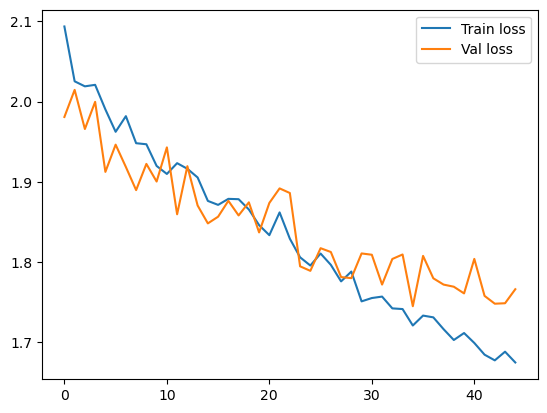

In [199]:
plt.plot(train_loss_per_epoch)
plt.plot(val_loss_per_epoch)
plt.legend(['Train loss','Val loss'])

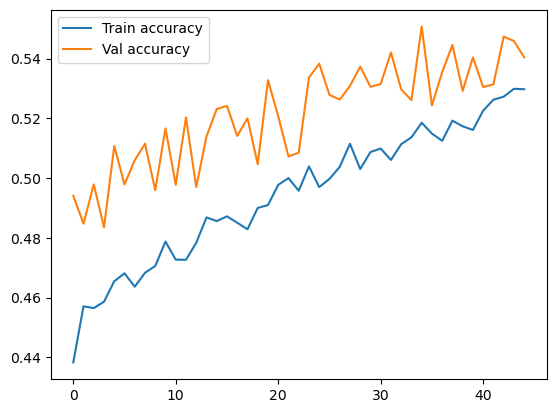

In [200]:
plt.plot(train_accuracy_per_epoch)
plt.plot(val_accuracy_per_epoch)
plt.legend(['Train accuracy','Val accuracy'])

In [ ]:
val_accuracy_per_epoch[-1]

In [201]:
prediction

tensor([ 8, 12,  3, 14,  0, 14, 33, 19, 14,  1,  0, 20,  2,  3, 14, 14, 14,  2,
         2, 12, 23, 14, 42,  2, 17, 14, 14, 16,  2, 20, 14, 14,  4, 19,  7, 19,
         4,  4, 26, 19, 19, 15, 14,  3, 14,  8, 39, 15, 13,  0, 20, 19,  7, 15,
        14, 13,  4, 16, 21, 21,  9, 17,  6, 17, 14, 15,  2, 27, 20,  4,  2,  0,
        11, 15, 13,  2, 14,  4, 14,  4, 12, 14, 13, 14, 15,  4,  4, 23,  2, 14,
         0,  0, 14, 15,  4, 20,  4,  7,  0, 27,  2, 14,  0,  2,  4, 14, 13, 21,
        22, 14, 14, 14,  2,  0, 11, 12,  2, 14,  2,  0, 22, 13, 14, 37, 14,  2,
        11, 37, 14,  0, 14,  2,  2,  2, 14, 36,  0, 15, 14,  4,  4, 13,  4,  0,
        22,  5, 28, 14, 14,  0], device='cuda:0')